In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
    break

In [ ]:
import pandas as pd
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import glob
import random
import os
from os import listdir
random.seed(100)
np.random.seed(100)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
breast_img = glob.glob('/content/drive/MyDrive/data/**/*.png', recursive = True)

In [ ]:
for imgname in breast_img[:3]:
    print(imgname)

/content/drive/MyDrive/data/cancer/10262_idx5_x1001_y1051_class1.png
/content/drive/MyDrive/data/cancer/10262_idx5_x1051_y1801_class1.png
/content/drive/MyDrive/data/cancer/10261_idx5_x2151_y1051_class1.png


In [ ]:
non_can_img = []
can_img = []

for img in breast_img:
    if img[-5] == '0' :
        non_can_img.append(img)
        if len(non_can_img)>=8000:
          break
for img in breast_img[::-1]:
    if img[-5] == '1' :
        can_img.append(img)
        if len(can_img)>=8000:
          break

In [ ]:
non_can_num = len(non_can_img)  # No cancer
can_num = len(can_img)   # Cancer

total_img_num = non_can_num + can_num

print('Number of Images of no cancer: {}' .format(non_can_num))   # images of Non cancer
print('Number of Images of cancer : {}' .format(can_num))   # images of cancer
print('Total Number of Images : {}' .format(total_img_num))

Number of Images of no cancer: 4066
Number of Images of cancer : 4151
Total Number of Images : 8217


In [ ]:
data_insight_1 = pd.DataFrame({'state of cancer' : ['0','1'],'Numbers of Patients' : [300,300]})
data_insight_1

,state of cancer,Numbers of Patients
0,0,300
1,1,300


In [ ]:
bar = px.bar(data_frame=data_insight_1, x = 'state of cancer', y='Numbers of Patients', color='state of cancer')
bar.update_layout(title_text='Number of Patients with cancer (1) and patients with no cancer (0)', title_x=0.5)
bar.show()

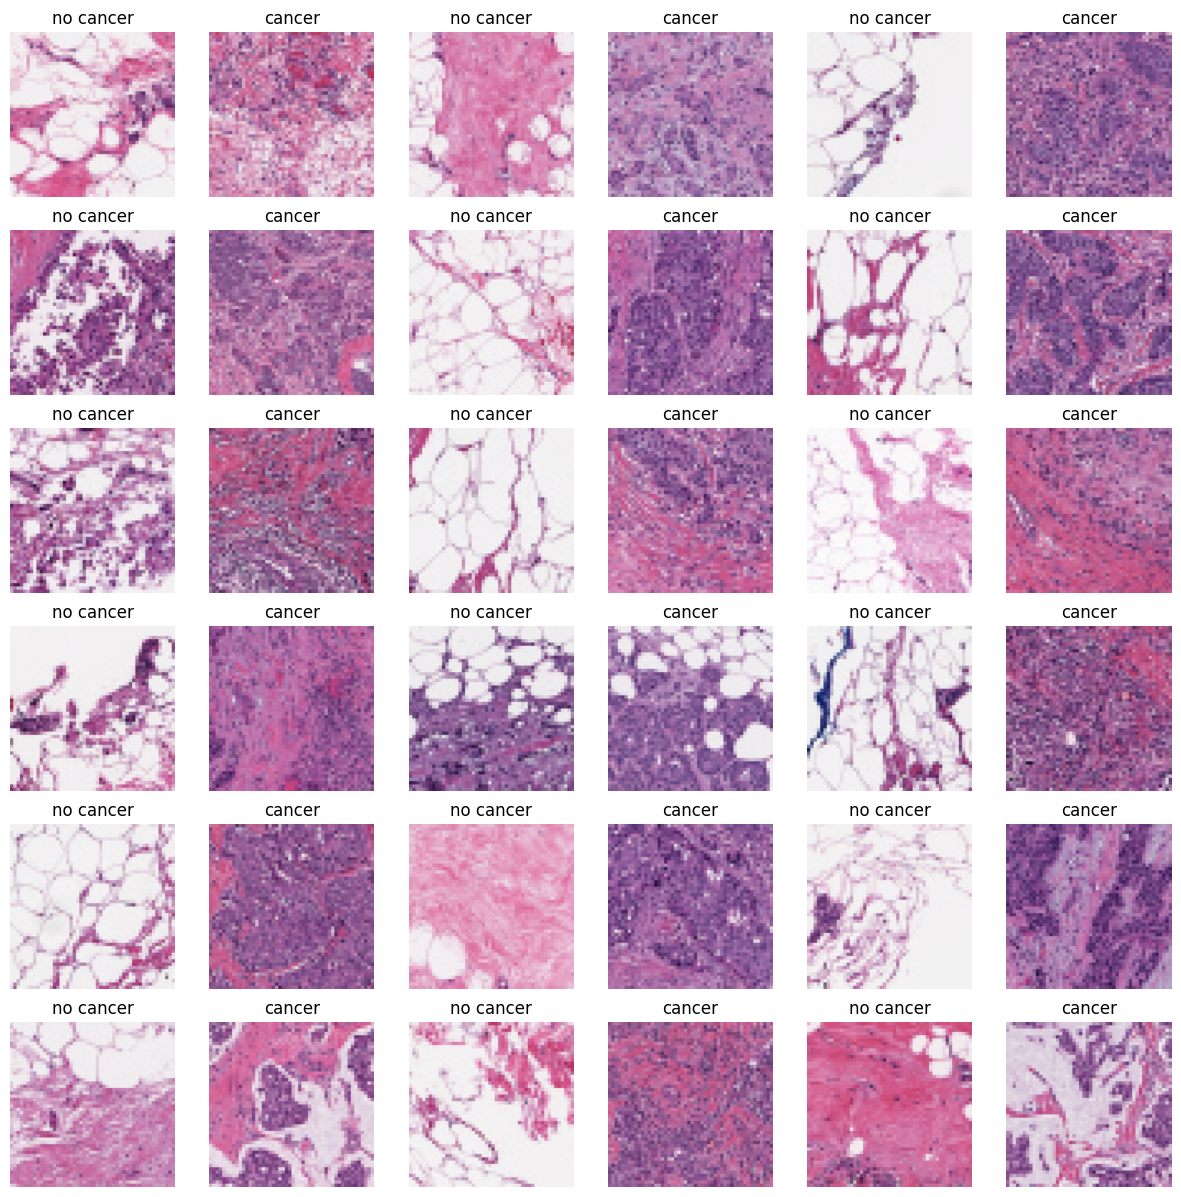

In [ ]:
import keras.utils as image

plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(non_can_img), 18)
some_can = np.random.randint(0, len(can_img), 18)

s = 0
for num in some_non:

        img = image.load_img((non_can_img[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1

s = 1
for num in some_can:

        img = image.load_img((can_img[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        plt.subplot(6, 6, 2*s)
        plt.axis('off')
        plt.title('cancer')
        plt.imshow(img.astype('uint8'))
        s += 1


In [ ]:
from matplotlib.image import imread
import cv2

some_non_img = random.sample(non_can_img, len(non_can_img))
some_can_img = random.sample(can_img, len(can_img))

non_img_arr = []
can_img_arr = []

for img in some_non_img:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50,  50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in some_can_img:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [ ]:
X = []
y = []
import numpy as np
breast_img_arr = np.concatenate((non_img_arr, can_img_arr))
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)

X = np.array(X)
y = np.array(y)
X = X.reshape(len(X), -1)
y = y.reshape(len(y))
print('X shape : {}' .format(y.shape))

X shape : (8217,)


<__array_function__ internals>:180: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))

X_train shape : (6162, 7500)
X_test shape : (2055, 7500)
y_train shape : (6162,)
y_test shape : (2055,)


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split


# VAE architecture parameters
latent_dim = 2
intermediate_dim = 256
batch_size = 128
epochs = 30

# Encoder architecture
inputs = Input(shape=(X_train.shape[1],))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Reparameterization trick to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = sampling([z_mean, z_log_var])

# Decoder architecture
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(X_train.shape[1], activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Combine the encoder and decoder to create the VAE model
vae = Model(inputs, x_decoded_mean)

# VAE loss function
reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, x_decoded_mean)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

# Compile the VAE with the VAE loss function
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Train the VAE
vae.fit(X_train, epochs=epochs, batch_size=batch_size)

# Generate synthetic data
synthetic_data = vae.predict(X_test)

# Combine synthetic data with labels
synthetic_data_with_labels = np.hstack((synthetic_data, y_test.reshape(-1, 1)))

# Save synthetic data as a CSV file
columns = [f"feature_{i}" for i in range(X_train.shape[1])] + ['label']
df_synthetic = pd.DataFrame(synthetic_data_with_labels, columns=columns)
df_synthetic.to_csv('synthetic_data.csv', index=False)

# Split the original data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Save original data as CSV files
df_train_original = pd.DataFrame(np.hstack((X_train, y_train.reshape(-1, 1))), columns=columns)
df_test_original = pd.DataFrame(np.hstack((X_test, y_test.reshape(-1, 1))), columns=columns)

df_train_original.to_csv('train_data.csv', index=False)
df_test_original.to_csv('test_data.csv', index=False)

Epoch 1/30
34/34 [==============================] - 4s 82ms/step - loss: nan
Epoch 2/30
34/34 [==============================] - 4s 133ms/step - loss: nan
Epoch 3/30
34/34 [==============================] - 3s 81ms/step - loss: nan
Epoch 4/30
34/34 [==============================] - 3s 79ms/step - loss: nan
Epoch 5/30
34/34 [==============================] - 3s 79ms/step - loss: nan
Epoch 6/30
34/34 [==============================] - 3s 96ms/step - loss: nan
Epoch 7/30
34/34 [==============================] - 4s 115ms/step - loss: nan
Epoch 8/30
34/34 [==============================] - 3s 78ms/step - loss: nan
Epoch 9/30
34/34 [==============================] - 3s 79ms/step - loss: nan
Epoch 10/30
34/34 [==============================] - 3s 78ms/step - loss: nan
Epoch 11/30
34/34 [==============================] - 4s 114ms/step - loss: nan
Epoch 12/30
34/34 [==============================] - 3s 99ms/step - loss: nan
Epoch 13/30
34/34 [==============================] - 3s 80ms/step - lo

In [ ]:
a=np.column_stack((X_train,y_train))
b=np.column_stack((X_test,y_test))

In [ ]:
a

array([[189, 148, 189, ..., 125, 183,   1],
       [132,  78, 136, ..., 240, 243,   0],
       [243, 242, 244, ..., 241, 244,   0],
       ...,
       [165, 116, 188, ..., 114, 189,   0],
       [189, 152, 227, ..., 191, 217,   0],
       [227, 214, 228, ..., 224, 229,   0]])

In [ ]:
c=pd.DataFrame(a)
d=pd.DataFrame(b)

In [ ]:
csv_filename = 'train.csv'
csv="test.csv"
c.to_csv(csv_filename, index=False)
d.to_csv(csv, index=False)

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [ ]:
# Defining the parameters grid for GridSearchCV
param_grid={'C':[0.1,1,10,100],
            'gamma':[0.0001,0.001,0.1,1],
            'kernel':['rbf','poly']}

# Creating a support vector classifier
svc=svm.SVC()

# Creating a model using GridSearchCV with the parameters grid
model=GridSearchCV(svc,param_grid)

In [ ]:
model.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']})

In [ ]:
svm_pred = model.predict(X_test)
accuracy = accuracy_score(svm_pred, y_test)
# Print the accuracy of the model
print(f"The model is {accuracy*100}% accurate")

The model is 95.33333333333334% accurate


In [ ]:
import pickle
filename = 'SVM_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
import pickle
filename="/content/SVM_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier= LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(random_state=0)

In [ ]:
lr_pred= classifier.predict(X_test)
accuracy = accuracy_score(lr_pred, y_test)

# Print the accuracy of the model
print(f"The model is {accuracy*100}% accurate")

The model is 90.88098918083463% accurate


In [ ]:
import pickle
filename = 'LR_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

In [ ]:
import pickle
filename="/content/LR_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.naive_bayes import GaussianNB
classifie = GaussianNB()
classifie.fit(X_train, y_train)

GaussianNB()

In [ ]:
nb_pred = classifie.predict(X_test)
accuracy = accuracy_score(nb_pred, y_test)

# Print the accuracy of the model
print(f"The model is {accuracy*100}% accurate")

The model is 77.20247295208655% accurate


In [ ]:
import pickle
filename = 'NB_model.sav'
pickle.dump(classifie, open(filename, 'wb'))

In [ ]:
import pickle
filename="/content/NB_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
svm_pred = classifier.predict(X_train)
lr_pred= classifier.predict(X_train)
nb_pred = classifie.predict(X_train)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
meta_X_train = np.column_stack((svm_pred, nb_pred,lr_pred))
meta_y_train = y_train

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
meta_model = Sequential()
meta_model.add(Dense(64, activation='relu', input_shape=(3,)))
meta_model.add(Dropout(0.2))
meta_model.add(Dense(1, activation='sigmoid'))
meta_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
meta_model.fit(meta_X_train, meta_y_train, epochs=10, batch_size=32)

Epoch 1/10
15/15 [==============================] - 0s 2ms/step - loss: 0.3744 - accuracy: 1.0000
Epoch 2/10
15/15 [==============================] - 0s 2ms/step - loss: 0.3402 - accuracy: 1.0000
Epoch 3/10
15/15 [==============================] - 0s 2ms/step - loss: 0.3126 - accuracy: 1.0000
Epoch 4/10
15/15 [==============================] - 0s 2ms/step - loss: 0.2793 - accuracy: 1.0000
Epoch 5/10
15/15 [==============================] - 0s 2ms/step - loss: 0.2515 - accuracy: 1.0000
Epoch 6/10
15/15 [==============================] - 0s 2ms/step - loss: 0.2221 - accuracy: 1.0000
Epoch 7/10
15/15 [==============================] - 0s 2ms/step - loss: 0.2004 - accuracy: 1.0000
Epoch 8/10
15/15 [==============================] - 0s 2ms/step - loss: 0.1797 - accuracy: 1.0000
Epoch 9/10
15/15 [==============================] - 0s 2ms/step - loss: 0.1583 - accuracy: 1.0000
Epoch 10/10
15/15 [==============================] - 0s 2ms/step - loss: 0.1423 - accuracy: 1.0000


In [ ]:
svm_val_predictions = model.predict(X_test)
nb_val_predictions = classifie.predict(X_test)
lr_val_predictions = classifier.predict(X_test)

5/5 [==============================] - 0s 49ms/step


ValueError: ignored

In [ ]:
meta_X_val = np.column_stack((svm_val_predictions, nb_val_predictions,lr_val_predictions))
stacking_predictions = meta_model.predict(meta_X_val)

5/5 [==============================] - 0s 2ms/step


In [ ]:
s=np.column_stack((stacking_predictions,y_test))
predictions = (meta_model.predict(meta_X_val) > 0.5).astype("int32")

5/5 [==============================] - 0s 2ms/step


In [ ]:
s=np.column_stack((predictions,y_test))
c=0
for i,j in s:
  if i!=j:
    c+=1

In [ ]:
accuracy=(0.94405594405)*100
accuracy

94.405594405

In [ ]:
accuracy=accuracy_score(predictions,y_test)
accuracy

0.9466666666666667

In [ ]:
X = []
y = []
import numpy as np
breast_img_arr = (non_img_arr+ can_img_arr)
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)

X = np.array(X)
y = np.array(y)

print('X shape : {}' .format(X.shape))

X shape : (600, 50, 50, 3)


In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

rate = 0.5
num = int(X.shape[0] * rate)

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)


print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))

X_train shape : (450, 50, 50, 3)
X_test shape : (150, 50, 50, 3)
y_train shape : (450, 2)
y_test shape : (150, 2)


In [ ]:
import tensorflow as tf
tf.random.set_seed(100)

In [ ]:
model = tf.keras.Sequential([
tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)),
tf.keras.layers.MaxPooling2D(strides = 2),
tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
tf.keras.layers.MaxPooling2D((3, 3),strides = 2),
tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
tf.keras.layers.MaxPooling2D((3, 3),strides =2),
tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
tf.keras.layers.MaxPooling2D((3, 3),strides =2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation = 'relu'),
tf.keras.layers.Dense(2, activation = 'softmax')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 128)       

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Create an instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 15 , batch_size = 75)

Epoch 1/15
6/6 [==============================] - 3s 597ms/step - loss: 0.3824 - accuracy: 0.8489 - val_loss: 0.4783 - val_accuracy: 0.7867
Epoch 2/15
6/6 [==============================] - 5s 811ms/step - loss: 0.3735 - accuracy: 0.8422 - val_loss: 0.4532 - val_accuracy: 0.8133
Epoch 3/15
6/6 [==============================] - 3s 494ms/step - loss: 0.3577 - accuracy: 0.8511 - val_loss: 0.4006 - val_accuracy: 0.8600
Epoch 4/15
6/6 [==============================] - 3s 515ms/step - loss: 0.3522 - accuracy: 0.8600 - val_loss: 0.3894 - val_accuracy: 0.8533
Epoch 5/15
6/6 [==============================] - 3s 498ms/step - loss: 0.3232 - accuracy: 0.8533 - val_loss: 0.3864 - val_accuracy: 0.8467
Epoch 6/15
6/6 [==============================] - 6s 1s/step - loss: 0.2954 - accuracy: 0.8733 - val_loss: 0.4209 - val_accuracy: 0.8400
Epoch 7/15
6/6 [==============================] - 3s 508ms/step - loss: 0.2812 - accuracy: 0.8956 - val_loss: 0.3733 - val_accuracy: 0.8467
Epoch 8/15
6/6 [=======

In [ ]:
model.evaluate(X_test,y_test)

5/5 [==============================] - 0s 51ms/step - loss: 0.3504 - accuracy: 0.8600


[0.3503636419773102, 0.8600000143051147]

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

5/5 [==============================] - 1s 91ms/step


In [ ]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(predictions,y_test)
accuracy

0.86

In [ ]:

model.save("my_cnn_model.h5")

In [ ]:
from tensorflow.keras.models import load_model
x=load_model("my_cnn_model.h5")

In [ ]:
img="/content/drive/MyDrive/bdataset/cancer/cancer/10260_idx5_x1051_y1051_class1.png"
c_img = cv2.imread(img, cv2.IMREAD_COLOR)
Xi= cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
X=[]
X.append(Xi)
X=np.array(X)
X = X.reshape(len(X), -1)

In [ ]:
result = x.predict(X)

ValueError: ignored

In [ ]:
result

array([1])

In [ ]:
a=pd.read_csv('/content/train.csv')
b=pd.read_csv('/content/test.csv')

In [ ]:
train=pd.DataFrame(a)
test=pd.DataFrame(b)

In [ ]:
train

,0,1,2,3,4,5,6,7,8,9,...,7491,7492,7493,7494,7495,7496,7497,7498,7499,7500
0,189,148,189,197,156,202,180,135,179,147,...,165,111,159,178,128,178,174,125,183,1
1,132,78,136,138,80,147,165,127,180,143,...,242,240,243,242,240,243,242,240,243,0
2,243,242,244,243,243,244,243,243,244,243,...,235,234,238,243,243,244,241,241,244,0
3,154,94,152,176,127,180,191,153,189,164,...,236,231,237,233,223,232,130,66,114,1
4,172,125,197,185,137,199,157,107,150,134,...,167,113,197,178,137,191,152,96,146,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6157,222,212,223,224,197,227,220,197,222,245,...,231,219,235,221,208,227,157,122,165,0
6158,184,138,192,148,87,147,143,88,137,147,...,171,113,177,167,114,182,158,99,163,0
6159,165,116,188,172,127,182,184,148,199,180,...,154,102,179,174,128,192,163,114,189,0
6160,189,152,227,173,129,219,185,147,226,198,...,215,196,218,171,146,206,211,191,217,0


In [ ]:
X_train=train.iloc[:,:-1]
X_test=test.iloc[:,:-1]
Y_train=train.iloc[:,-1]
Y_test=test.iloc[:,-1]

In [ ]:
len(Y_train)

6162

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, Y_train)

GaussianNB()

In [ ]:
nb_pred = classifier.predict(X_test)
accuracy = accuracy_score(nb_pred, Y_test)

# Print the accuracy of the model
print(f"The model is {accuracy*100}% accurate")

The model is 78.19951338199513% accurate


In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
svc=svm.SVC()
svc.fit(X_train,Y_train)

SVC()

In [ ]:
re=svc.predict(X_test)
acc=accuracy_score(re,Y_test)
acc

0.9474452554744526

In [ ]:
import pickle
filename = 'SVM_model.sav'
pickle.dump(svc, open(filename, 'wb'))

In [ ]:
import pickle
filename="/content/SVM_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier= LogisticRegression(random_state=0)
classifier.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [ ]:
lr_pred= classifier.predict(X_test)
accuracy = accuracy_score(lr_pred, Y_test)

# Print the accuracy of the model
print(f"The model is {accuracy*100}% accurate")

The model is 93.47931873479318% accurate


In [ ]:
import pickle
filename = 'LR_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

In [ ]:
import pickle
filename="/content/LR_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))